In [1]:
from RF_model import randomforestclassifier  # Random forest was selected

Data loaded successfully
Data split successfully
Scaling done successfully
Feature selection done successfully
Starting cross-validation


/Users/aronalagaraj/miniconda3/envs/ecotoxicMOFs/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 57  70 126 144 146 148 150 151 162 166 169 173 174 175 185 187 191 192
 196] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/aronalagaraj/miniconda3/envs/ecotoxicMOFs/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Finished cross-validation
0.81 accuracy with a standard deviation of 0.06
0.80 balanced accuracy with a standard deviation of 0.06
0.80 f1-macro with a standard deviation of 0.06
0.60 MCC with a standard deviation of 0.13
Fitting model


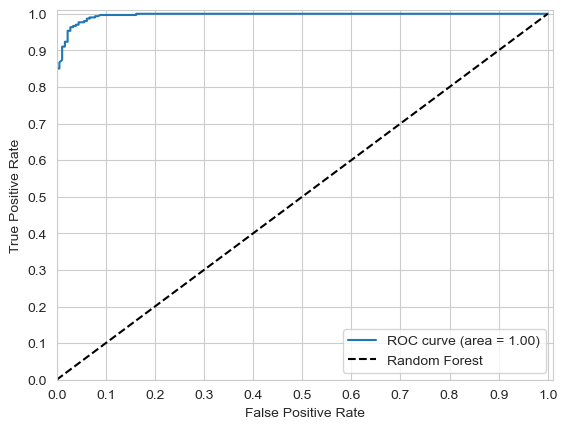

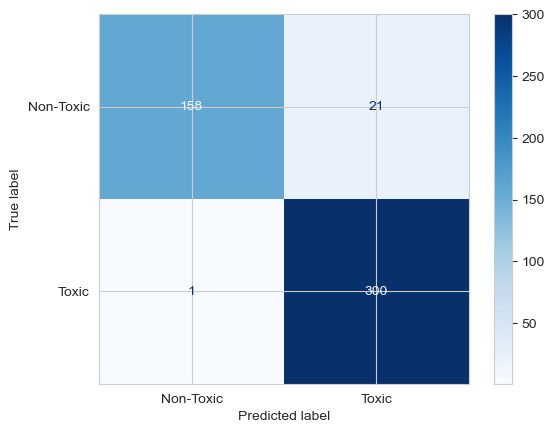

Train Accuracy score: 0.95
Train Recall score: 1.00


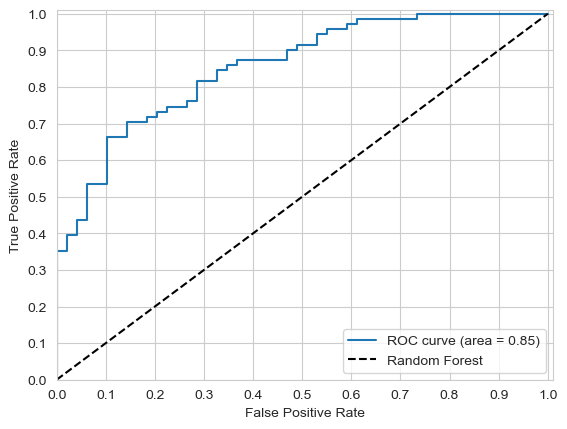

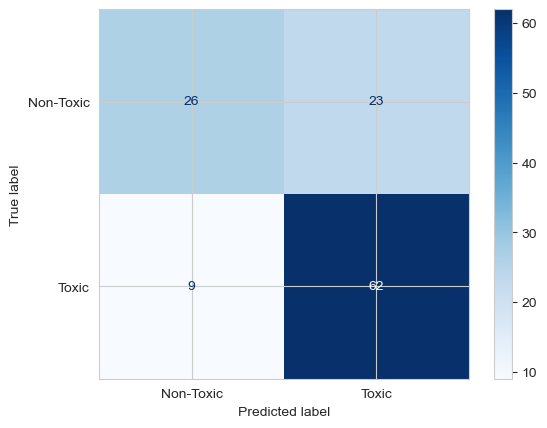

Validation Accuracy score: 0.73
Validation Recall score: 0.87


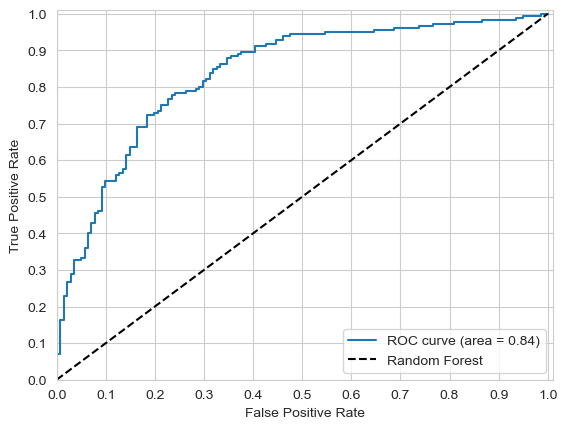

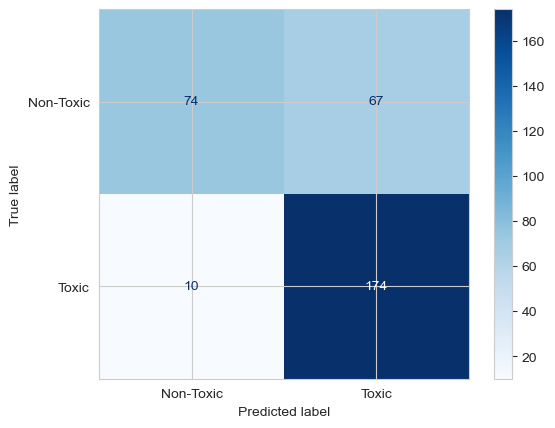

Test Accuracy score: 0.76
Test Recall score: 0.95


In [2]:
model, X_train, X_val, X_test, y_train, y_val, y_test, selector = randomforestclassifier()

In [3]:
import pandas as pd

test_data = pd.read_csv('data/unseen_data/unseen_descriptors.csv')  # Change as needed
mask = selector.get_support()  # List of features
selected_features = test_data.loc[:, mask]

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/aronalagaraj/miniconda3/envs/ecotoxicMOFs/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


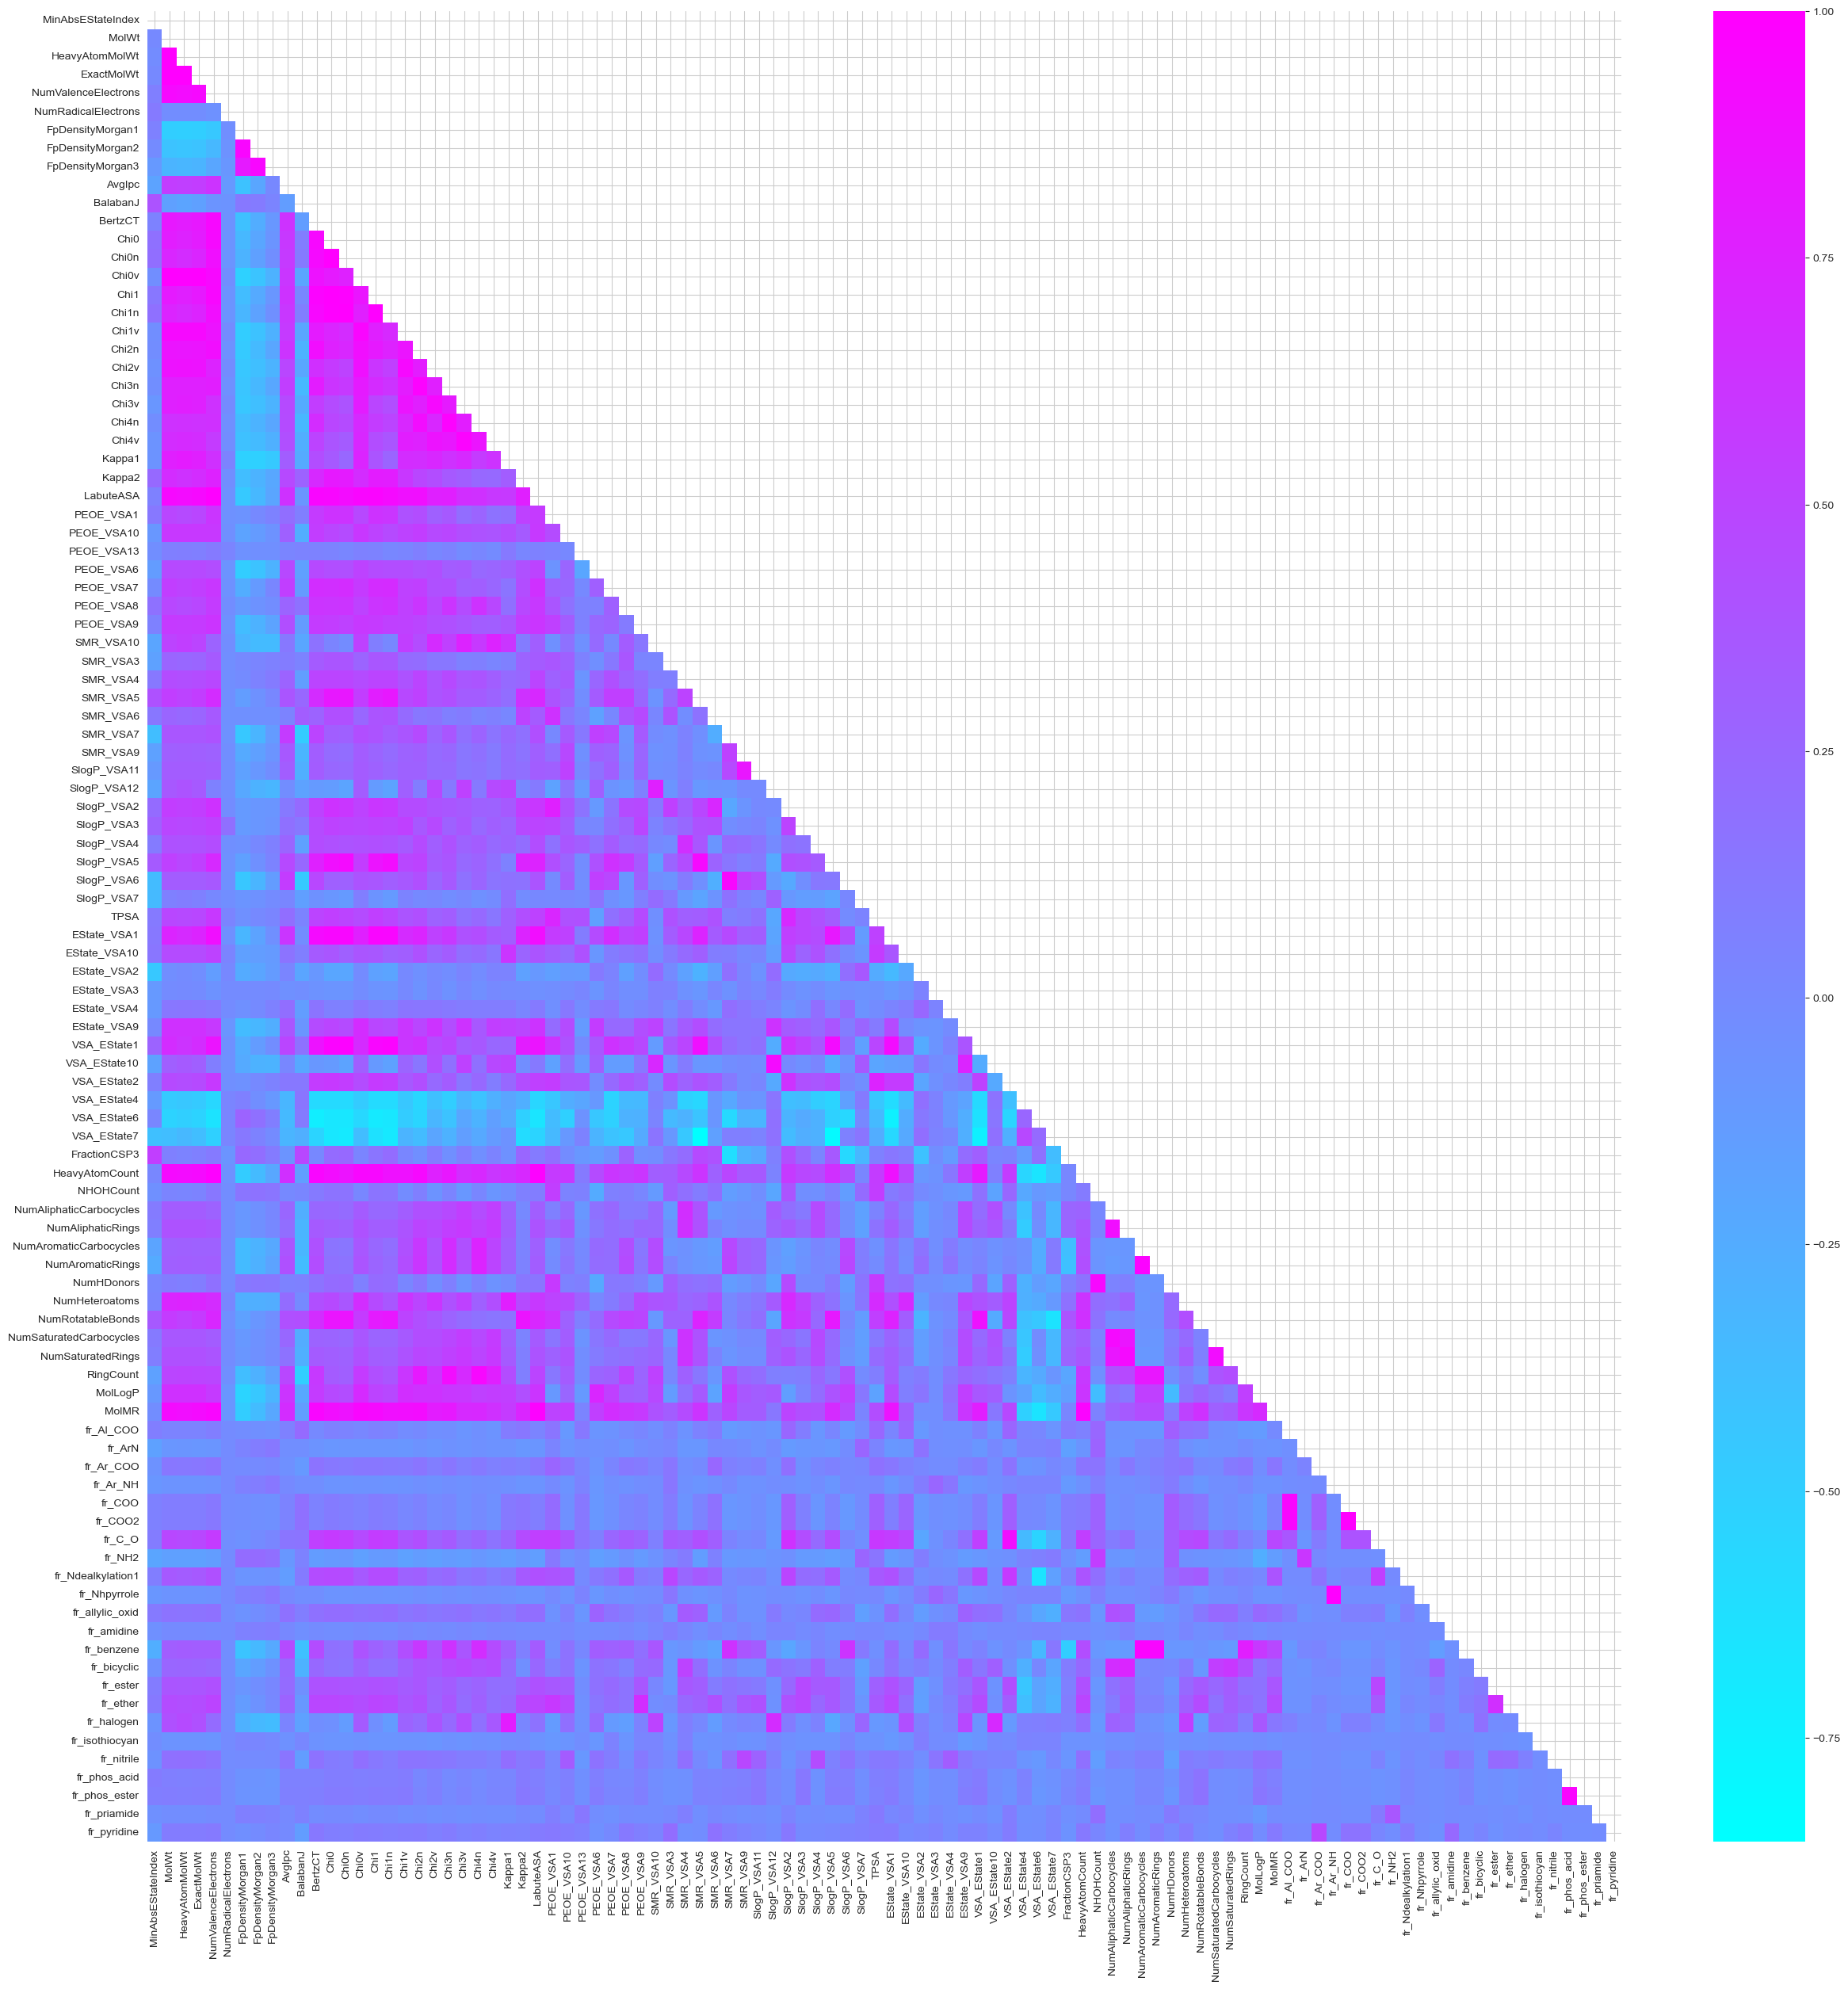

In [5]:
complete_X = pd.read_csv('data/training_data/descriptors.csv')  # Change as needed
complete_X = selector.transform(complete_X)
complete_X = pd.DataFrame(complete_X, columns=selected_features.columns)

# Constructing a correlation matrix
mask = np.triu(np.ones_like(complete_X.corr()))
plt.figure(figsize=(30, 30))
sns.heatmap(complete_X.corr(), annot=False, fmt='.0f', mask=mask, cmap='cool')
plt.show()

In [6]:
# Importing SHAP and initialising the JS visualization code
import shap

shap.initjs()

In [7]:
# Creating an explainer object and calculating SHAP values
explainer = shap.Explainer(model.predict, X_val, feature_names=selected_features.columns)
shap_values = explainer(X_val)

PermutationExplainer explainer: 121it [00:45,  2.07it/s]                         


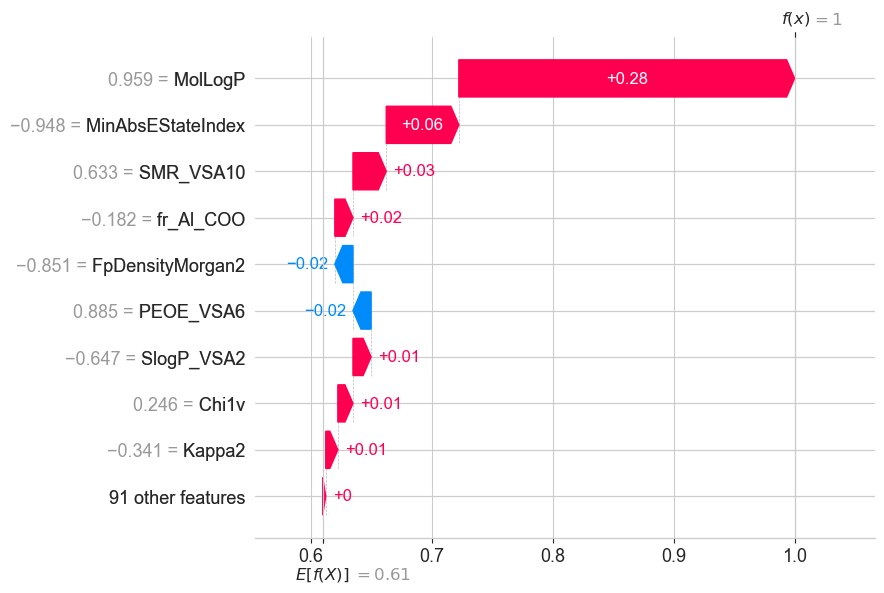

In [8]:
shap.plots.waterfall(shap_values[0])  # Waterfall plots for each sample, change index to see other samples

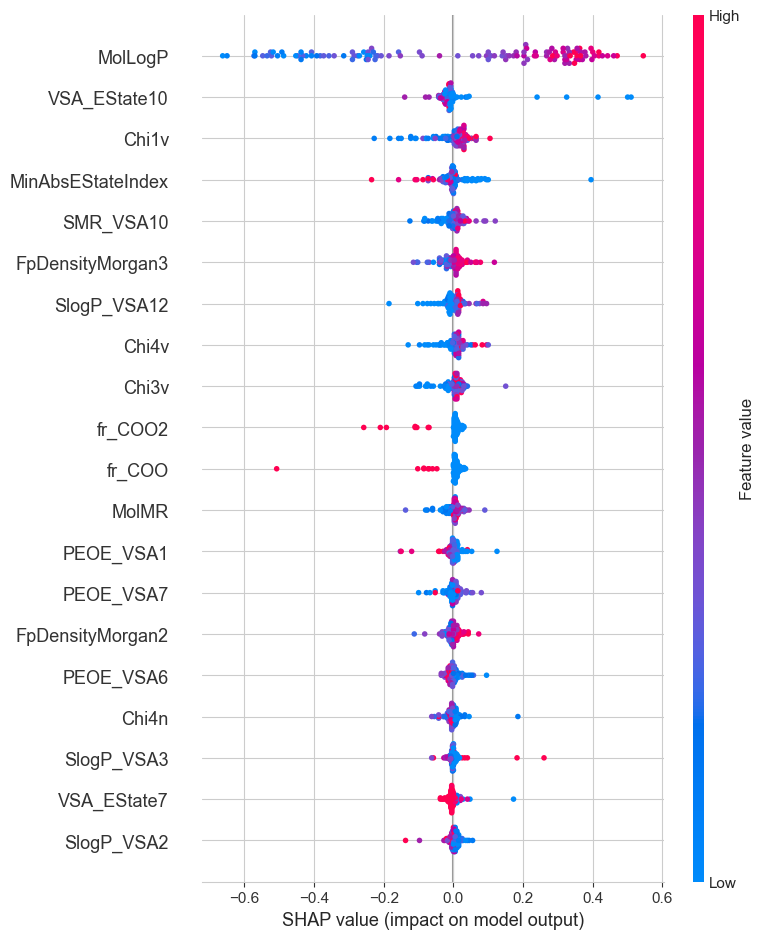

In [9]:
shap.summary_plot(shap_values)  # Summary plot representing all points

In [10]:
# Isolating the SHAP values for the positive and negative classes to see the effect of the features on the classes
complete_val = pd.DataFrame(X_val, columns=selected_features.columns)
complete_val.insert(loc=100, column='Class', value=y_val.reset_index(drop=True))

ones = complete_val.loc[complete_val['Class'] == 1]
zeros = complete_val.loc[complete_val['Class'] == 0]

In [11]:
ones = ones.drop('Class', axis=1)
zeros = zeros.drop('Class', axis=1)

In [12]:
one_shap_values = explainer(ones)
zero_shap_values = explainer(zeros)

PermutationExplainer explainer: 72it [00:26,  1.67it/s]                        
PermutationExplainer explainer: 50it [00:18,  1.25it/s]                        


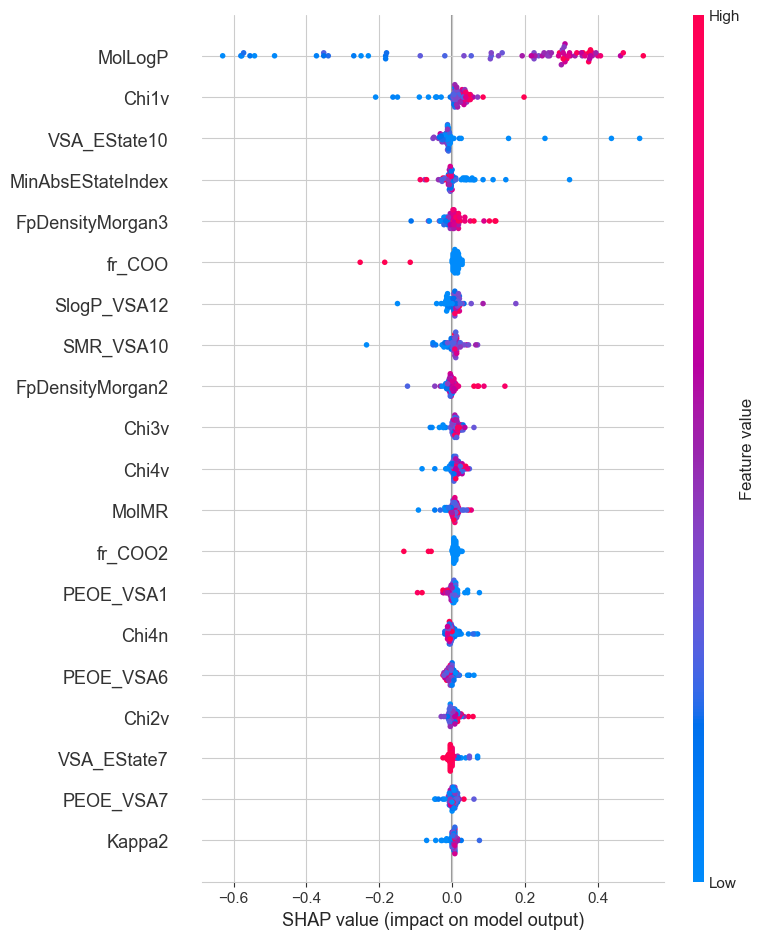

In [13]:
shap.summary_plot(one_shap_values)

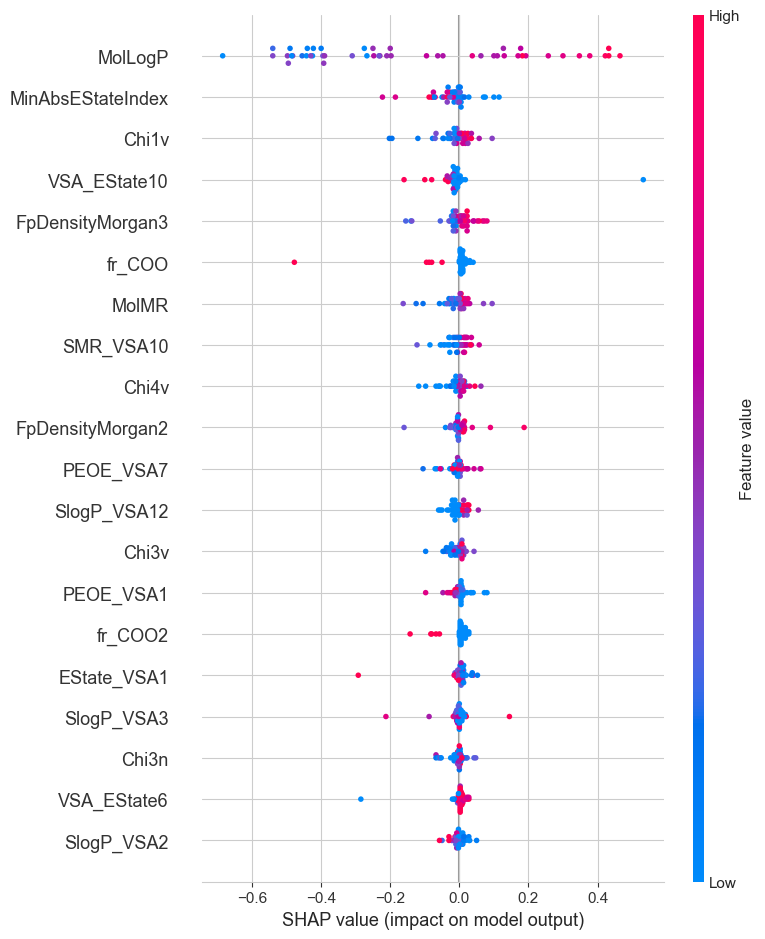

In [14]:
shap.summary_plot(zero_shap_values)

In [15]:
# Using feature importance to see another metric of how important the features are
feature_scores = pd.Series(model.feature_importances_, index=selected_features.columns).sort_values(ascending=False)
feature_scores

MolLogP                0.313312
MinAbsEStateIndex      0.031681
SlogP_VSA2             0.028490
VSA_EState10           0.023136
Chi1v                  0.022848
                         ...   
fr_Ar_COO              0.000000
NumRadicalElectrons    0.000000
fr_phos_acid           0.000000
fr_phos_ester          0.000000
fr_Ndealkylation1      0.000000
Length: 100, dtype: float64

/var/folders/wl/vkrd4x2j7fs5_ybd9y74b2xm0000gn/T/ipykernel_33530/3795917055.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index)


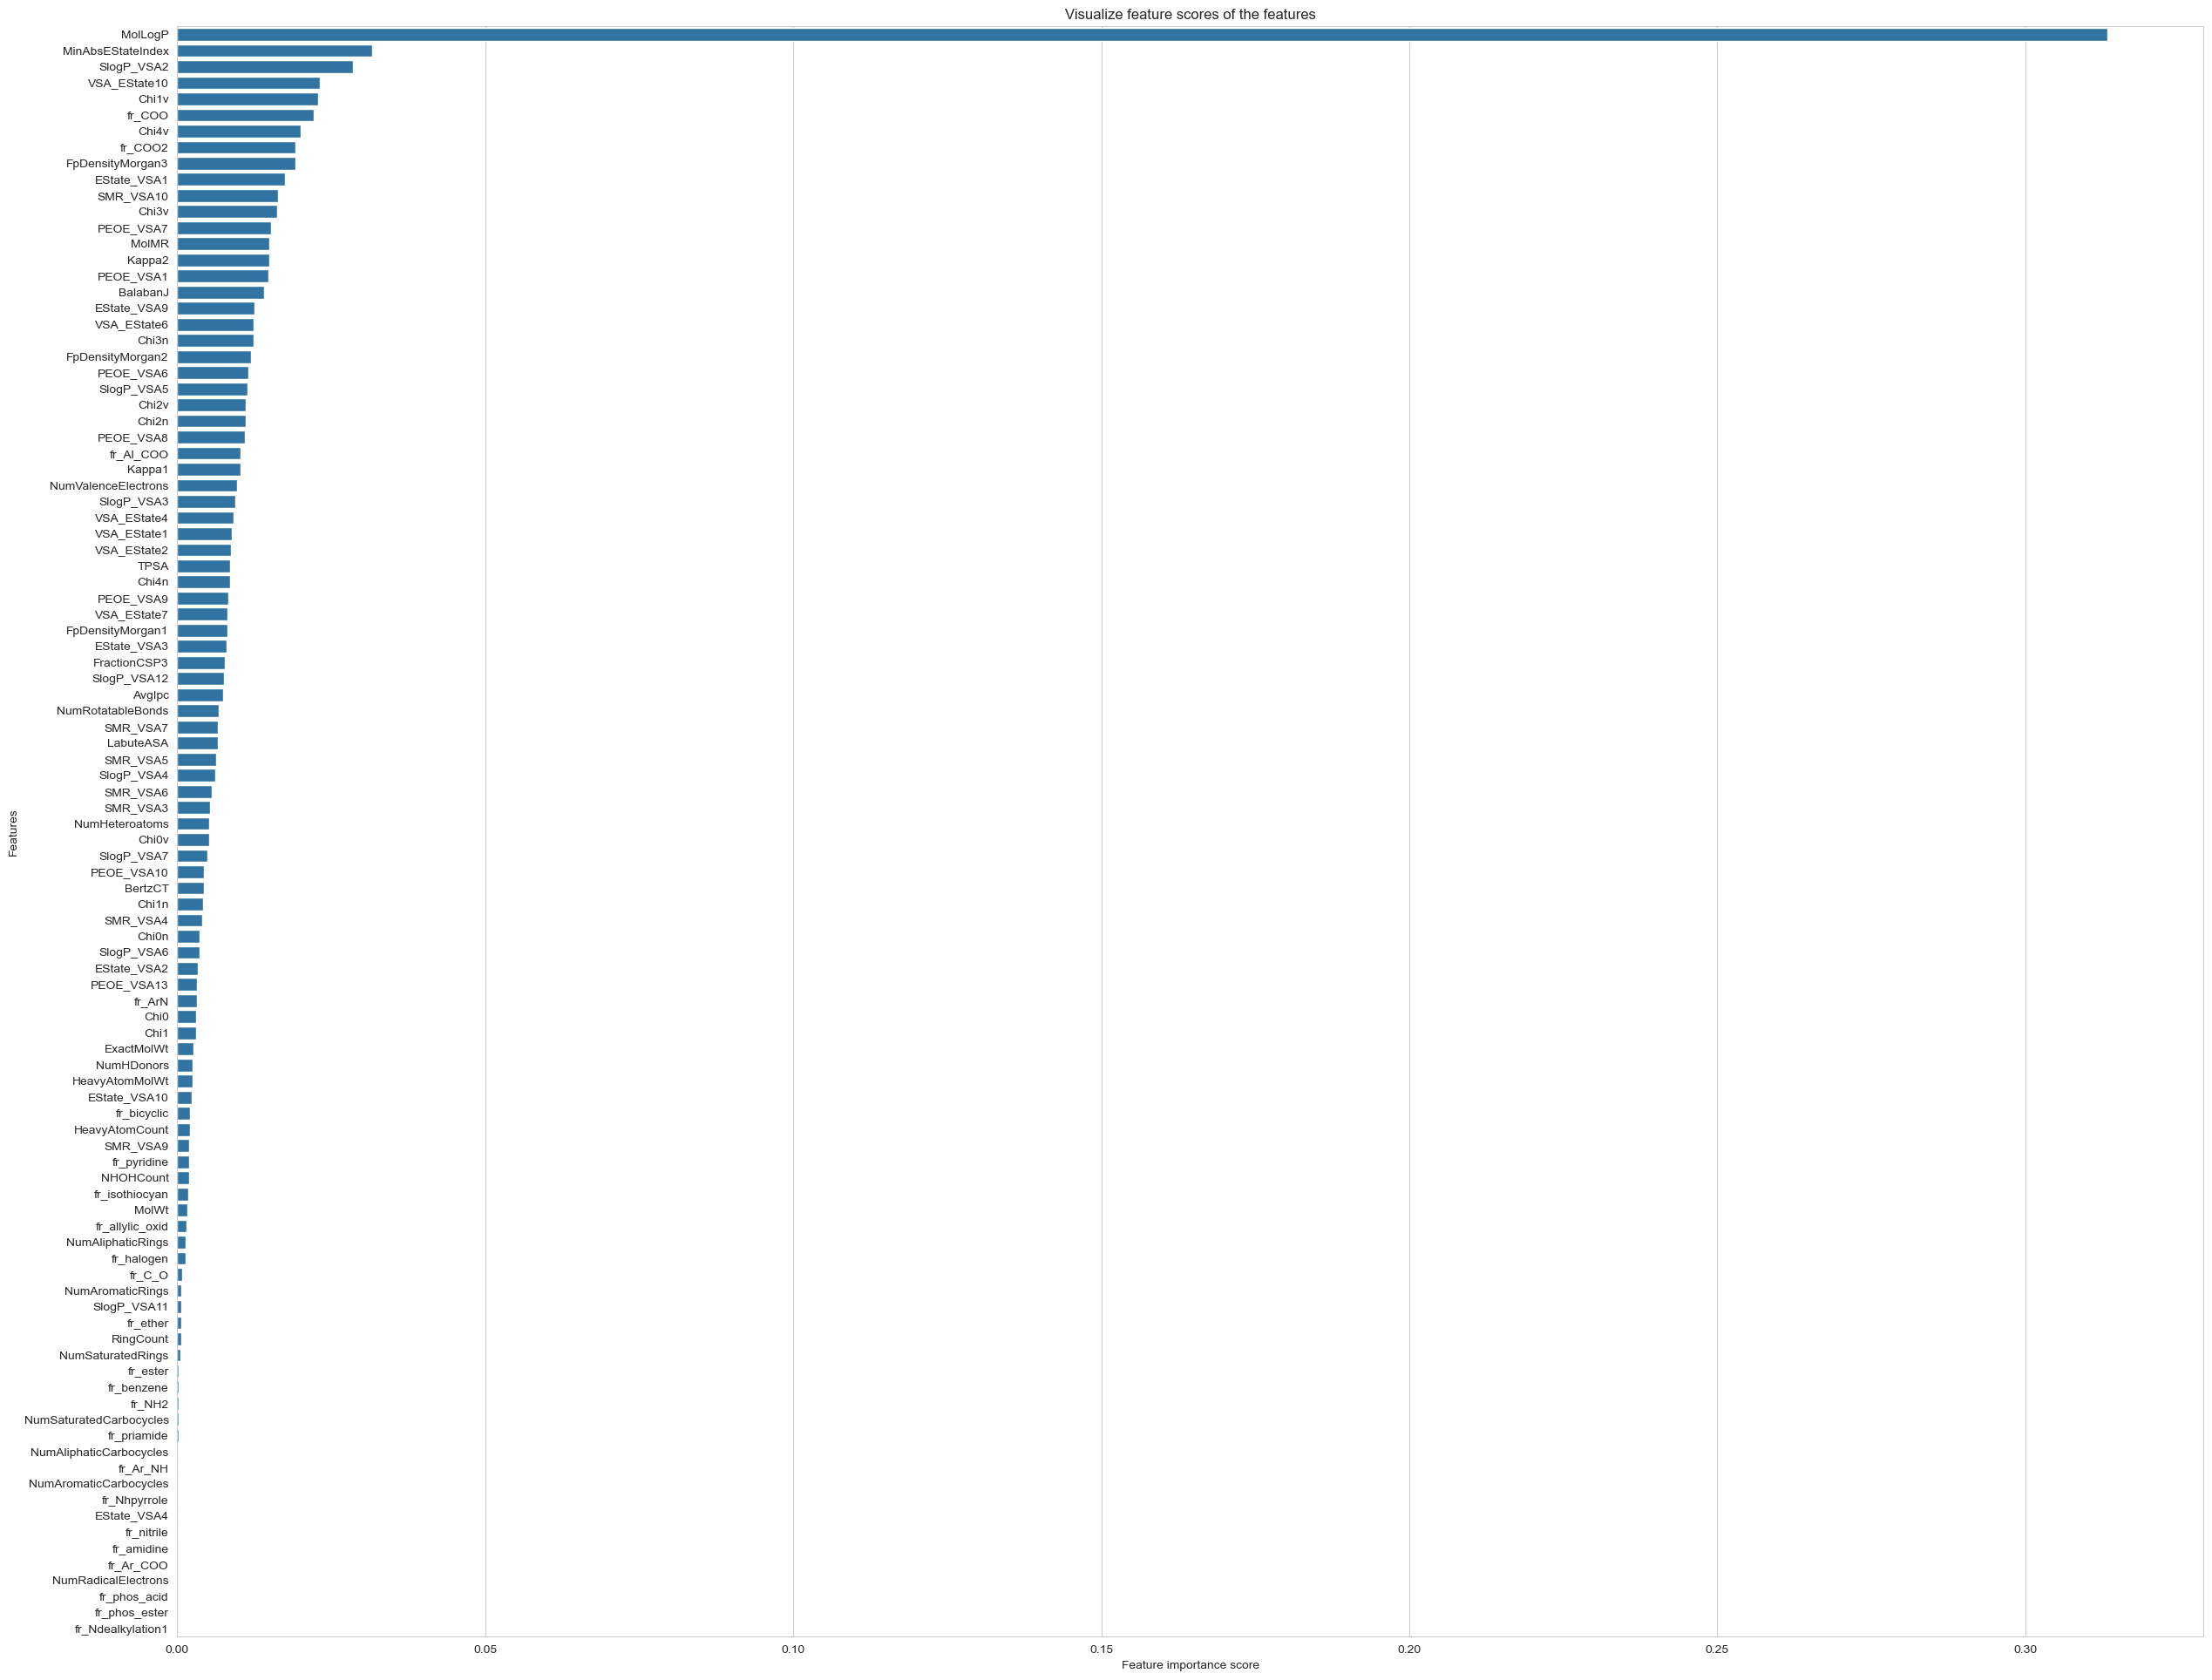

In [16]:
# Plot of feature importance scores
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()